In [1]:
# High Priority Analysis Changes
# Standardize dataset loading
# First frame is slightly different

## Analyses
# Try running with high-dimension latent space and using UMAP to visualize
# Perturbation analysis (altering a single gene and observing the change) in a continual manner

In [2]:
%load_ext autoreload
%autoreload 2
%env WANDB_NOTEBOOK_NAME exploration.ipynb
%env WANDB_SILENT true

env: WANDB_NOTEBOOK_NAME=exploration.ipynb
env: WANDB_SILENT=true


In [3]:
from collections import defaultdict
import os

import inept
from IPython import display
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

# Set params
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_FOLDER = os.path.join(os.path.abspath(''), '../data')
PLOT_FOLDER = os.path.join(os.path.abspath(''), '../plots')
TEMP_FOLDER = os.path.join(os.path.abspath(''), 'temp')

# Disable gradients
torch.set_grad_enabled(False)

# Style
sns.set_context('paper', font_scale=1.25)
sns.set_style('darkgrid')
sns.set_palette('Accent')
PALETTE = 'husl'

### Load Files

In [4]:
# Animation parameters
generalize = True
num_nodes_max = 300
run_id = '3iiibc12'

In [5]:
# Load run from the wandb API
api = wandb.Api()
run = api.run(f'oafish/INEPT/{run_id}')

# Load configs
config = defaultdict(lambda: {})
for k, v in run.config.items():
    dict_name, key = k.split('/')
    config[dict_name][key] = v
config = dict(config)

# Load model
fname = f'trained_models/policy_{run.summary["stage"]:02}.mdl'
run.file(fname).download(TEMP_FOLDER, replace=True)
policy = torch.load(os.path.join(TEMP_FOLDER, fname)).to(DEVICE).eval()
policy.actor.set_action_std(1e-7)  # Place in execution mode (TODO: 0)

In [6]:
# Reproducibility
torch.manual_seed(config['note']['seed'])
if DEVICE == 'cuda': torch.cuda.manual_seed(config['note']['seed'])
np.random.seed(config['note']['seed'])

In [7]:
# Load data
dataset_name = config['data']['dataset']

if dataset_name == 'scNMT':
    dataset_dir = os.path.join(DATA_FOLDER, 'UnionCom/scNMT')
    M1 = pd.read_csv(os.path.join(dataset_dir, 'Paccessibility_300.txt'), delimiter=' ', header=None).to_numpy()
    M2 = pd.read_csv(os.path.join(dataset_dir, 'Pmethylation_300.txt'), delimiter=' ', header=None).to_numpy()
    M3 = pd.read_csv(os.path.join(dataset_dir, 'RNA_300.txt'), delimiter=' ', header=None).to_numpy()
    T1 = pd.read_csv(os.path.join(dataset_dir, 'type1.txt'), delimiter=' ', header=None).to_numpy().flatten()
    T2 = pd.read_csv(os.path.join(dataset_dir, 'type2.txt'), delimiter=' ', header=None).to_numpy().flatten()
    T3 = pd.read_csv(os.path.join(dataset_dir, 'type3.txt'), delimiter=' ', header=None).to_numpy().flatten()

elif dataset_name == 'BrainChromatin':
    nrows = None
    M1 = pd.read_csv(os.path.join(DATA_FOLDER, 'brainchromatin/multiome_rna_counts.tsv'), delimiter='\t', nrows=nrows).transpose()
    M2 = pd.read_csv(os.path.join(DATA_FOLDER, 'brainchromatin/multiome_atac_gene_activities.tsv'), delimiter='\t', nrows=nrows).transpose()
    M2 = M2.transpose()[M1.index].transpose()
    meta = pd.read_csv(os.path.join(DATA_FOLDER, 'brainchromatin/multiome_cell_metadata.txt'), delimiter='\t')
    meta_names = pd.read_csv(os.path.join(DATA_FOLDER, 'brainchromatin/multiome_cluster_names.txt'), delimiter='\t')
    meta_names = meta_names[meta_names['Assay'] == 'Multiome ATAC']
    meta = pd.merge(meta, meta_names, left_on='ATAC_cluster', right_on='Cluster.ID', how='left')
    meta.index = meta['Cell.ID']
    T1 = T2 = np.array(meta.transpose()[M1.index].transpose()['Cluster.Name'])
    F1, F2 = M1.columns, M2.columns
    M1, M2 = M1.to_numpy(), M2.to_numpy()

elif dataset_name == 'scGEM':
    M1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/scGEM/GeneExpression.txt'), delimiter=' ', header=None).to_numpy()
    M2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/scGEM/DNAmethylation.txt'), delimiter=' ', header=None).to_numpy()
    T1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/scGEM/type1.txt'), delimiter=' ', header=None).to_numpy()
    T2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/scGEM/type2.txt'), delimiter=' ', header=None).to_numpy()
    F1 = np.loadtxt(os.path.join(DATA_FOLDER, 'UnionCom/scGEM/gex_names.txt'), dtype='str')
    F2 = np.loadtxt(os.path.join(DATA_FOLDER, 'UnionCom/scGEM/dm_names.txt'), dtype='str')

# MMD-MA data
elif dataset_name == 'MMD-MA':
    M1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped1.txt'), delimiter='\t', header=None).to_numpy()
    M2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped2.txt'), delimiter='\t', header=None).to_numpy()
    T1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type1.txt'), delimiter='\t', header=None).to_numpy()
    T2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type2.txt'), delimiter='\t', header=None).to_numpy()

# Random data
elif dataset_name == 'Random':
    num_nodes = 100
    M1 = torch.rand((num_nodes, 8), device=DEVICE)
    M2 = torch.rand((num_nodes, 16), device=DEVICE)

else: assert False, 'No matching dataset found.'

# Parameters
num_nodes = M1.shape[0] if generalize else config['data']['num_nodes']
num_nodes = min(num_nodes, num_nodes_max)
modalities = [[M1, M2, M3][2]]
types = [[T1, T2, T3][2]]

# Modify data
modalities = inept.utilities.normalize(*modalities, keep_array=True)  # Normalize
# modalities = inept.utilities.pca_features(*modalities, num_features=(512, 512), keep_array=True)  # PCA features (2 min for 8k x 35+k)
subsample = inept.utilities.subsample_nodes(*modalities, *types, num_nodes=num_nodes, keep_array=True)  # Subsample nodes
modalities, types = subsample[:len(modalities)], subsample[len(modalities):]
# modalities = inept.utilities.subsample_features(*modalities, num_features=(16, 16), keep_array=True)  # Subsample features

# Cast types
modalities = [torch.tensor(Mx, dtype=torch.float32, device=DEVICE) for Mx in modalities]

In [8]:
# Initialize environment
env = inept.environments.trajectory(*modalities, **config['env'], device=DEVICE)
for stage in config['stages']['env']: env.set_rewards(stage)  # Set to final stage

### Plot Performance

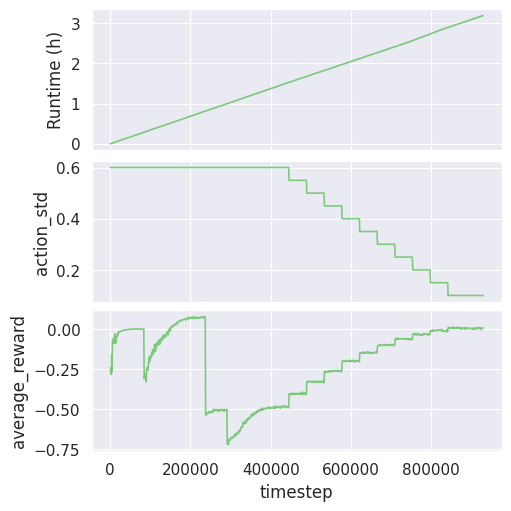

In [9]:
# Load history from wandb
history = run.history(samples=2000)
history['timestep'] = history['end_timestep']
history['Runtime (h)'] = history['_runtime'] / 60**2

# Plot
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True, layout='constrained')
axs = axs.flatten()
sns.lineplot(history, x='timestep', y='Runtime (h)', ax=axs[0])
sns.lineplot(history, x='timestep', y='action_std', ax=axs[1])
sns.lineplot(history, x='timestep', y='average_reward', ax=axs[2])
plt.show()

### Animate Latent Space

##### Functions

In [10]:
def animate(
    policy,
    env,
    create_func,
    update_func,
    steps=config['train']['max_ep_timesteps'],
    timescale=10,  # Factor speedup
    skip=None,  # Only show frames (frame % skip) == 0
    save_to_file=True,
    fname=config['data']['dataset'],
    file_type='mp4',  # gif for export, mp4 for preview
    verbose=True,
    **kwargs,
):
    "Generate animation with provided hyperparameters"
    # Default parameters
    if skip is None: skip = 3 if file_type == 'gif' else 1
    assert file_type in ('mp4', 'gif'), f'File type {file_type} not supported.'

    # Calculated parameters
    frames = int(steps / skip) + 1  # +1 for initial state
    interval = int(1e3 * env.delta * skip / timescale)
    fps = int(1e3 / interval)  # fps should be ~30 for gif

    # Create figure and reset environment
    fig, ax, attributes = create_func(env, **kwargs)

    # Formatting
    ax.set_aspect('equal')
    ax.set_xlim([-env.pos_bound-.2, env.pos_bound+.2])
    ax.set_ylim([-env.pos_bound-.2, env.pos_bound+.2])

    # Update function
    update = lambda frame: update_func(frame, policy=policy, env=env, skip=skip, verbose=verbose, ax=ax, **attributes, **kwargs)

    # CLI
    if verbose: print(f'Total Steps: {steps}')

    # Run animation
    ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=interval)
    if save_to_file:
        if file_type == 'mp4': writer = animation.FFMpegWriter(fps=fps, metadata={'artist': 'INEPT'}, extra_args=['-vcodec', 'libx264'], bitrate=8e3)
        elif file_type == 'gif': writer = animation.FFMpegWriter(fps=fps)
        ani.save(os.path.join(PLOT_FOLDER, f'{fname}.{file_type}'), writer=writer)  # Save
    else: display(ani.to_jshtml())  # Display

    # CLI
    if verbose: print()

def env_step(policy, env):
    "Step environment"
    with torch.no_grad():
            state = env.get_state(include_modalities=True)
            rewards, finished = env.step(policy.act_macro(state, max_batch=config['train']['max_batch']).detach())
    return rewards, finished

def create_integration(
    env,
    c=None,
    center=False,
    **kwargs,
):
    "Generic figure creation function"
    fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
    pos = env.get_state().cpu()[:, :2]
    if center: pos = pos - pos.mean(dim=0)  # Center for visualization
    sct = ax.scatter(*pos.T, c=[sns.color_palette(PALETTE, c.max()+1).as_hex()[i] for i in c])

    return fig, ax, dict(sct=sct)

def update_integration(
    frame,
    policy,
    env,
    sct,
    ax,
    skip=1,
    center=False,
    verbose=True,
    **kwargs,
):
    "Figure update function for integration"
    # CLI
    if verbose: print(f'Processed: {frame:04}', end='\r')

    # Escape on initial frame
    if frame == 0:
        ax.set_title(f'Reward: {0: 0.4f}')
        return sct

    # Escape if finished
    if env.finished(): ax.set_title(f'Finished'); return

    # Step environment
    for _ in range(skip):
        rewards, finished = env_step(policy, env)
        if finished: break

    # Draw
    pos = env.get_state().cpu()[:, :2]
    if center: pos = pos - pos.mean(dim=0)  # Center for visualization
    sct.set_offsets(pos)
    ax.set_title(f'Reward: {rewards.cpu().mean().item(): 0.4f}')
    return sct

def create_trajectory(*args, **kwargs): return create_integration(*args, **kwargs)

def update_trajectory(
    frame,
    policy,
    env,
    sct,
    ax,
    tracked_node_idx,
    skip=1,
    arrow_kwargs={},
    verbose=True,
    **kwargs,
):
    "Figure update function for trajectory"
    # Default arguments
    arrow_kwargs_default = dict(width=.1, color='blue', head_width=0)
    for k, v in arrow_kwargs_default.items():
        if k not in arrow_kwargs: arrow_kwargs[k] = v

    # CLI
    if verbose: print(f'Processed: {frame:04}', end='\r')

    # Escape on initial frame
    if frame == 0:
        ax.set_title(f'Reward: {0: 0.4f}')
        return sct

    # Escape if finished
    if env.finished(): ax.set_title(f'Finished'); return

    # Save old position
    pos_old = env.get_state().cpu()[:, :2]

    # Step environment
    for _ in range(skip):
        rewards, finished = env_step(policy, env)
        if finished: break

    # Draw
    pos = env.get_state().cpu()[:, :2]
    sct.set_offsets(pos)
    ax.set_title(f'Reward: {rewards.cpu().mean().item(): 0.4f}')

    # Draw trajectory arrow
    dpos = pos[tracked_node_idx] - pos_old[tracked_node_idx]
    ax.arrow(*pos_old[tracked_node_idx], *dpos, **arrow_kwargs)

    return sct

##### Running

In [11]:
# Universal animation parameters
seed = 42
file_type = 'mp4'
max_steps = 400
suffix = '-3'

# Process
steps = config['train']['max_ep_timesteps'] if max_steps is None else min(max_steps, config['train']['max_ep_timesteps'])
c = np.unique(types[0].flatten(), return_inverse=True)[1]  # TODO: Extend to non-matching modalities

In [12]:
%matplotlib agg
# Reproducibility
torch.manual_seed(seed)

# Integration animation
env.reset()
animate(
    policy,
    env,
    steps=steps,
    create_func=create_integration,
    update_func=update_integration,
    c=c,
    fname=f'{config["data"]["dataset"]}{suffix}',
    file_type=file_type)
pos, vel = env.pos.detach().clone(), env.vel.detach().clone()  # Save steady state

# Get distance from origin for steady state
print(f'Centering square distance: {pos.mean(dim=0).square().sum().cpu().item():.3f}')

Total Steps: 400
Processed: 0400
Centering square distance: 0.127


In [13]:
%matplotlib agg
# Reproducibility
torch.manual_seed(seed)

# Trajectory analysis
node_to_analyze, node_to_copy = 0, 2  # Which node will be analyzed
env.pos, env.vel = pos.detach().clone(), vel.detach().clone()  # Reset env to steady state
if node_to_copy is None: env.pos[node_to_analyze] = env.pos_bound * 2 * (torch.rand(2) - .5)  # Randomize node position
else: env.pos[node_to_analyze] = env.pos[node_to_copy]  # Copy node position
animate(
    policy,
    env,
    steps=steps,
    create_func=create_trajectory,
    update_func=update_trajectory,
    c=c,
    tracked_node_idx=node_to_analyze,
    fname=f'{config["data"]["dataset"]}{suffix}_trajectory',
    file_type=file_type)

Total Steps: 400
Processed: 0400


In [14]:
%matplotlib agg
# Reproducibility
torch.manual_seed(seed)

# Feature modification
features_to_randomize = [(0, list(range(len(modalities[0]) // 2)))]  # (modality, [features])
env.pos, env.vel = pos.detach().clone(), vel.detach().clone()  # Reset env to steady state
# env.reset()  # Reset env to new
old_modalities = [m.detach().clone() for m in env.modalities]
for modality, features in features_to_randomize:
    for feature in features:
        env.modalities[modality][:, feature] = torch.normal(
            env.modalities[modality][:, feature].mean().expand(env.modalities[modality].shape[0]),
            env.modalities[modality][:, feature].std().expand(env.modalities[modality].shape[0]),
)
animate(
    policy,
    env,
    steps=steps,
    create_func=create_integration,
    update_func=update_integration,
    c=c,
    fname=f'{config["data"]["dataset"]}{suffix}_feature',
    file_type=file_type)
env.modalities = old_modalities

Total Steps: 400
Processed: 0400
